In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns


az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
raw_df = pd.read_csv("../data/iphone_trends.csv", parse_dates=["week"])

raw_df.tail()

,week,iphone_11,iphone_12,iphone_13,iphone_14,iphone_15
256,2023-10-22,10,10,14,16,23
257,2023-10-29,10,9,13,15,22
258,2023-11-05,11,10,15,17,22
259,2023-11-12,11,10,16,17,24
260,2023-11-19,12,11,17,17,24


In [3]:
releases_df = pd.DataFrame(
    data=[
        {"model": "iphone_11", "release_date": "September 20, 2019"},
        {"model": "iphone_12", "release_date": "October 23, 2020"},
        {"model": "iphone_13", "release_date": "September 24, 2021"},
        {"model": "iphone_14", "release_date": "September 16, 2022"},
        {"model": "iphone_15", "release_date": "September 22, 2023"},
    ]
)

release_dates_df = releases_df.assign(
    release_week=lambda x: (
        pd.to_datetime(x["release_date"]).dt.to_period("W-SAT").dt.start_time
        - pd.DateOffset(days=7)
    )
)

release_dates_df

,model,release_date,release_week
0,iphone_11,"September 20, 2019",2019-09-08
1,iphone_12,"October 23, 2020",2020-10-11
2,iphone_13,"September 24, 2021",2021-09-12
3,iphone_14,"September 16, 2022",2022-09-04
4,iphone_15,"September 22, 2023",2023-09-10


In [4]:
data_df = (
    raw_df.copy()
    .melt(id_vars=["week"], var_name="model", value_name="search")
    .merge(right=release_dates_df, on="model")
    .drop(columns=["release_date"])
    .assign(
        age=lambda x: (x["week"].max() - x["week"]).dt.days / 7,
        model_age=lambda x: (x["week"] - x["release_week"]).dt.days / 7,
    )
)

data_df.head()

,week,model,search,release_week,age,model_age
0,2018-11-25,iphone_11,0,2019-09-08,260.0,-41.0
1,2018-12-02,iphone_11,0,2019-09-08,259.0,-40.0
2,2018-12-09,iphone_11,0,2019-09-08,258.0,-39.0
3,2018-12-16,iphone_11,0,2019-09-08,257.0,-38.0
4,2018-12-23,iphone_11,0,2019-09-08,256.0,-37.0


Text(0.5, 1.0, 'Google Trends for iPhone Models (Worldwide)')

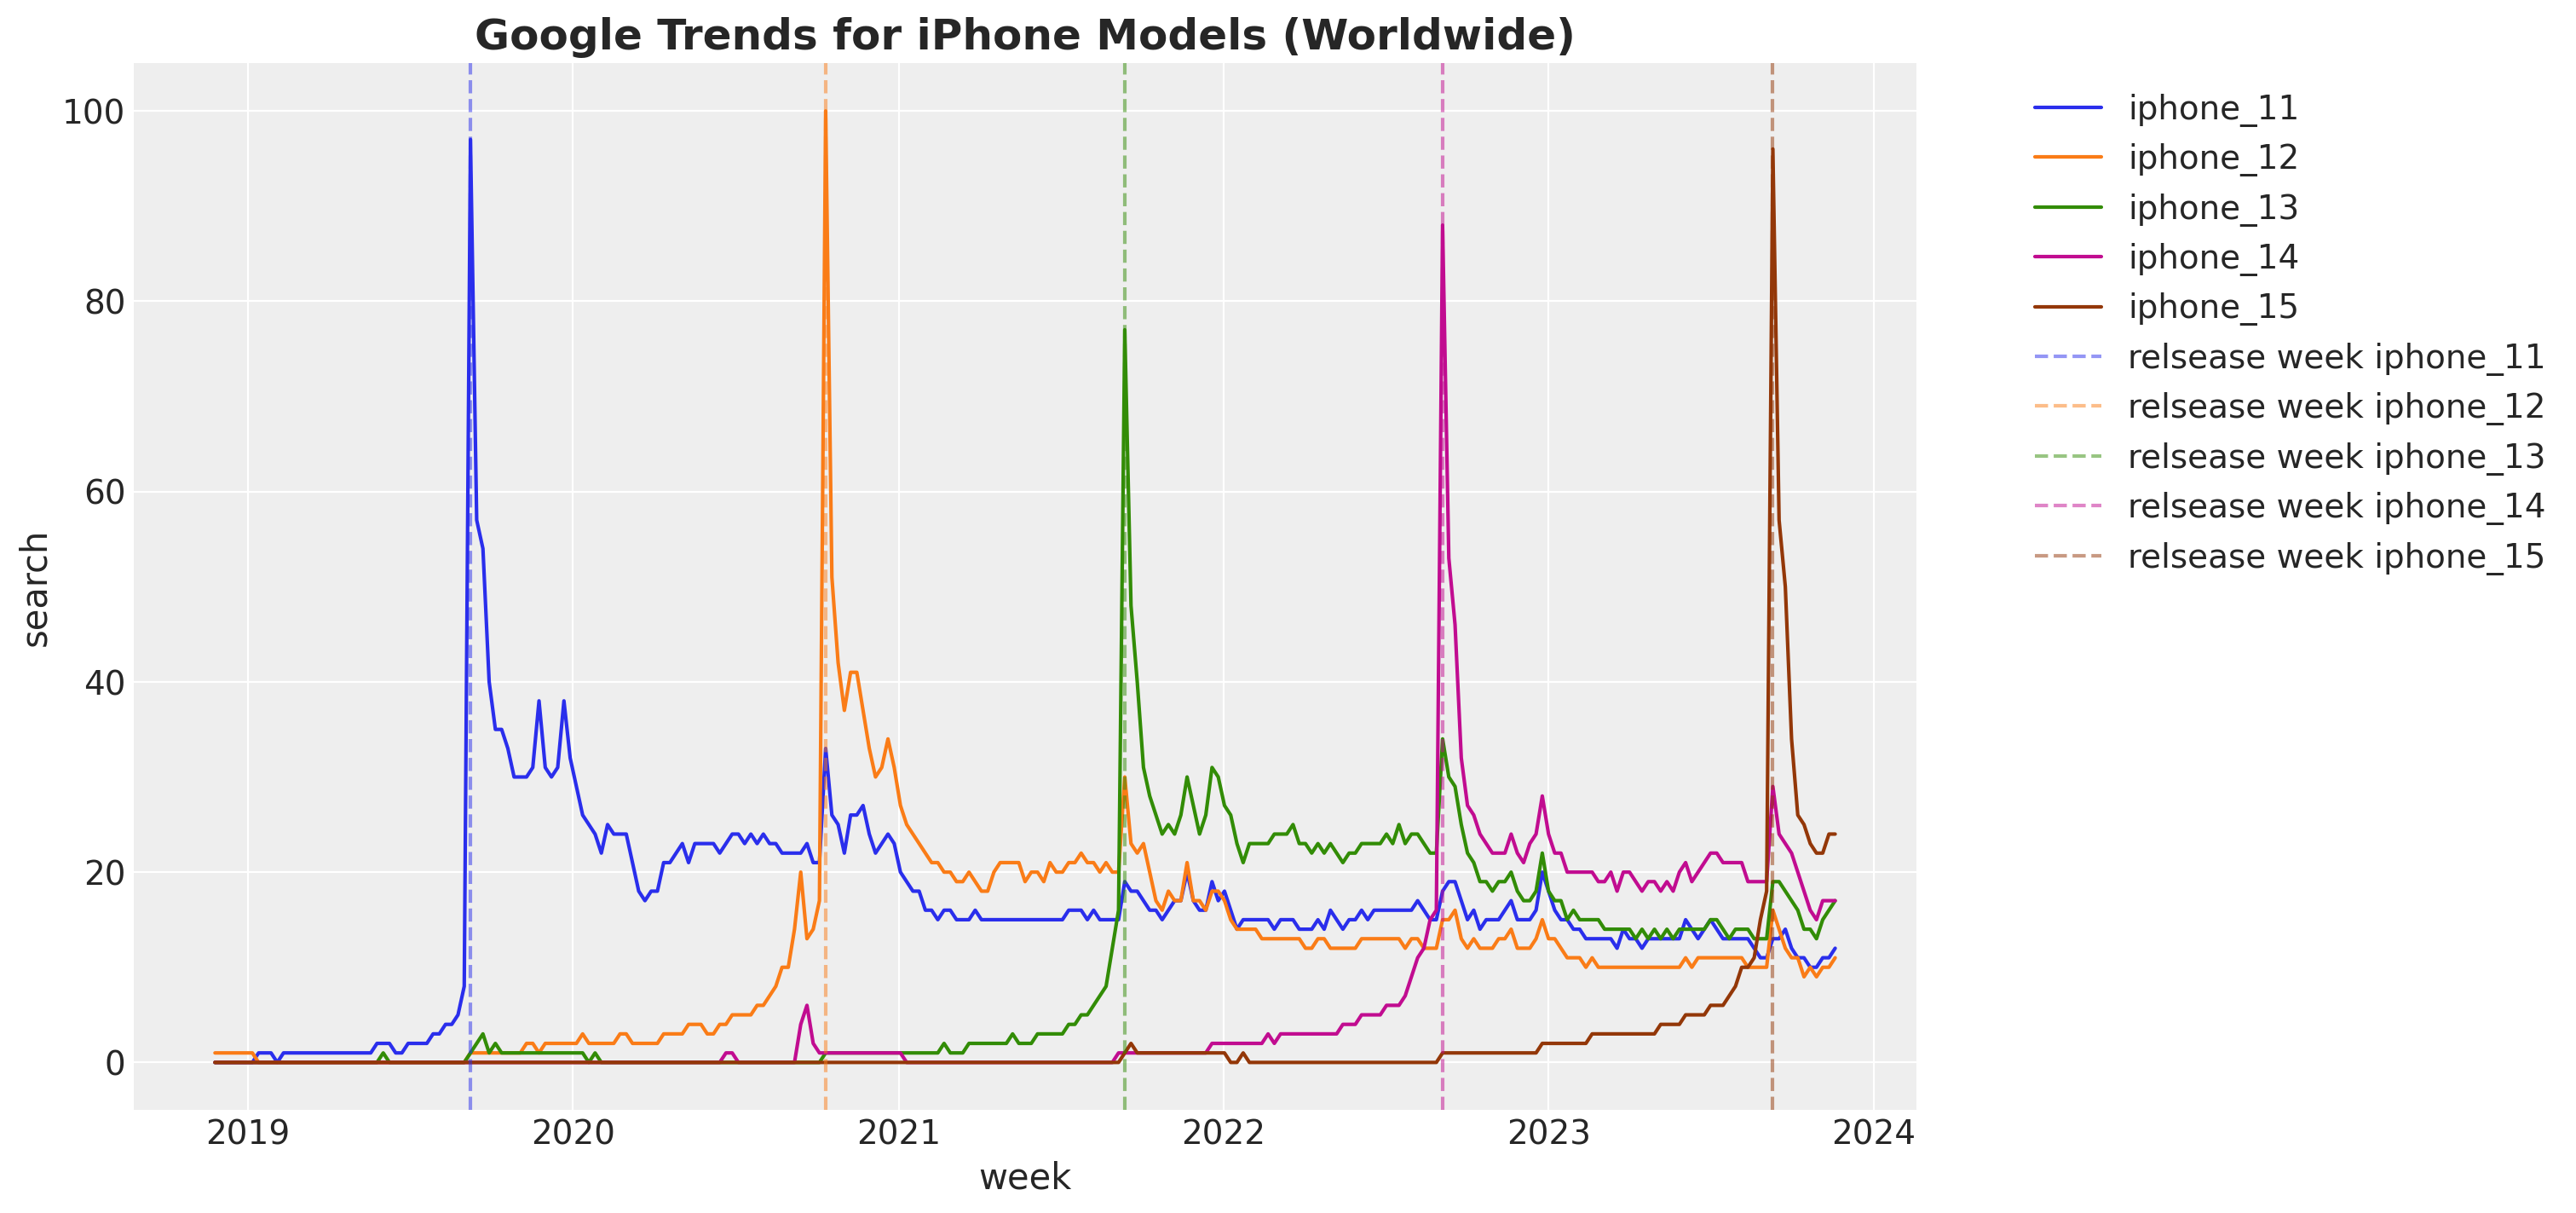

In [8]:
fig, ax = plt.subplots(figsize=(15, 7))

sns.lineplot(
    data=data_df,
    x="week",
    y="search",
    hue="model",
    ax=ax,
)

for i, model in enumerate(release_dates_df["model"]):
    release_week = release_dates_df.query(f"model == '{model}'")["release_week"].item()
    ax.axvline(
        release_week,
        color=f"C{i}",
        linestyle="--",
        alpha=0.5,
        label=f"relsease week {model}",
    )

ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_title(
    label="Google Trends for iPhone Models (Worldwide)", fontsize=18, fontweight="bold"
)

<Axes: xlabel='week', ylabel='model'>

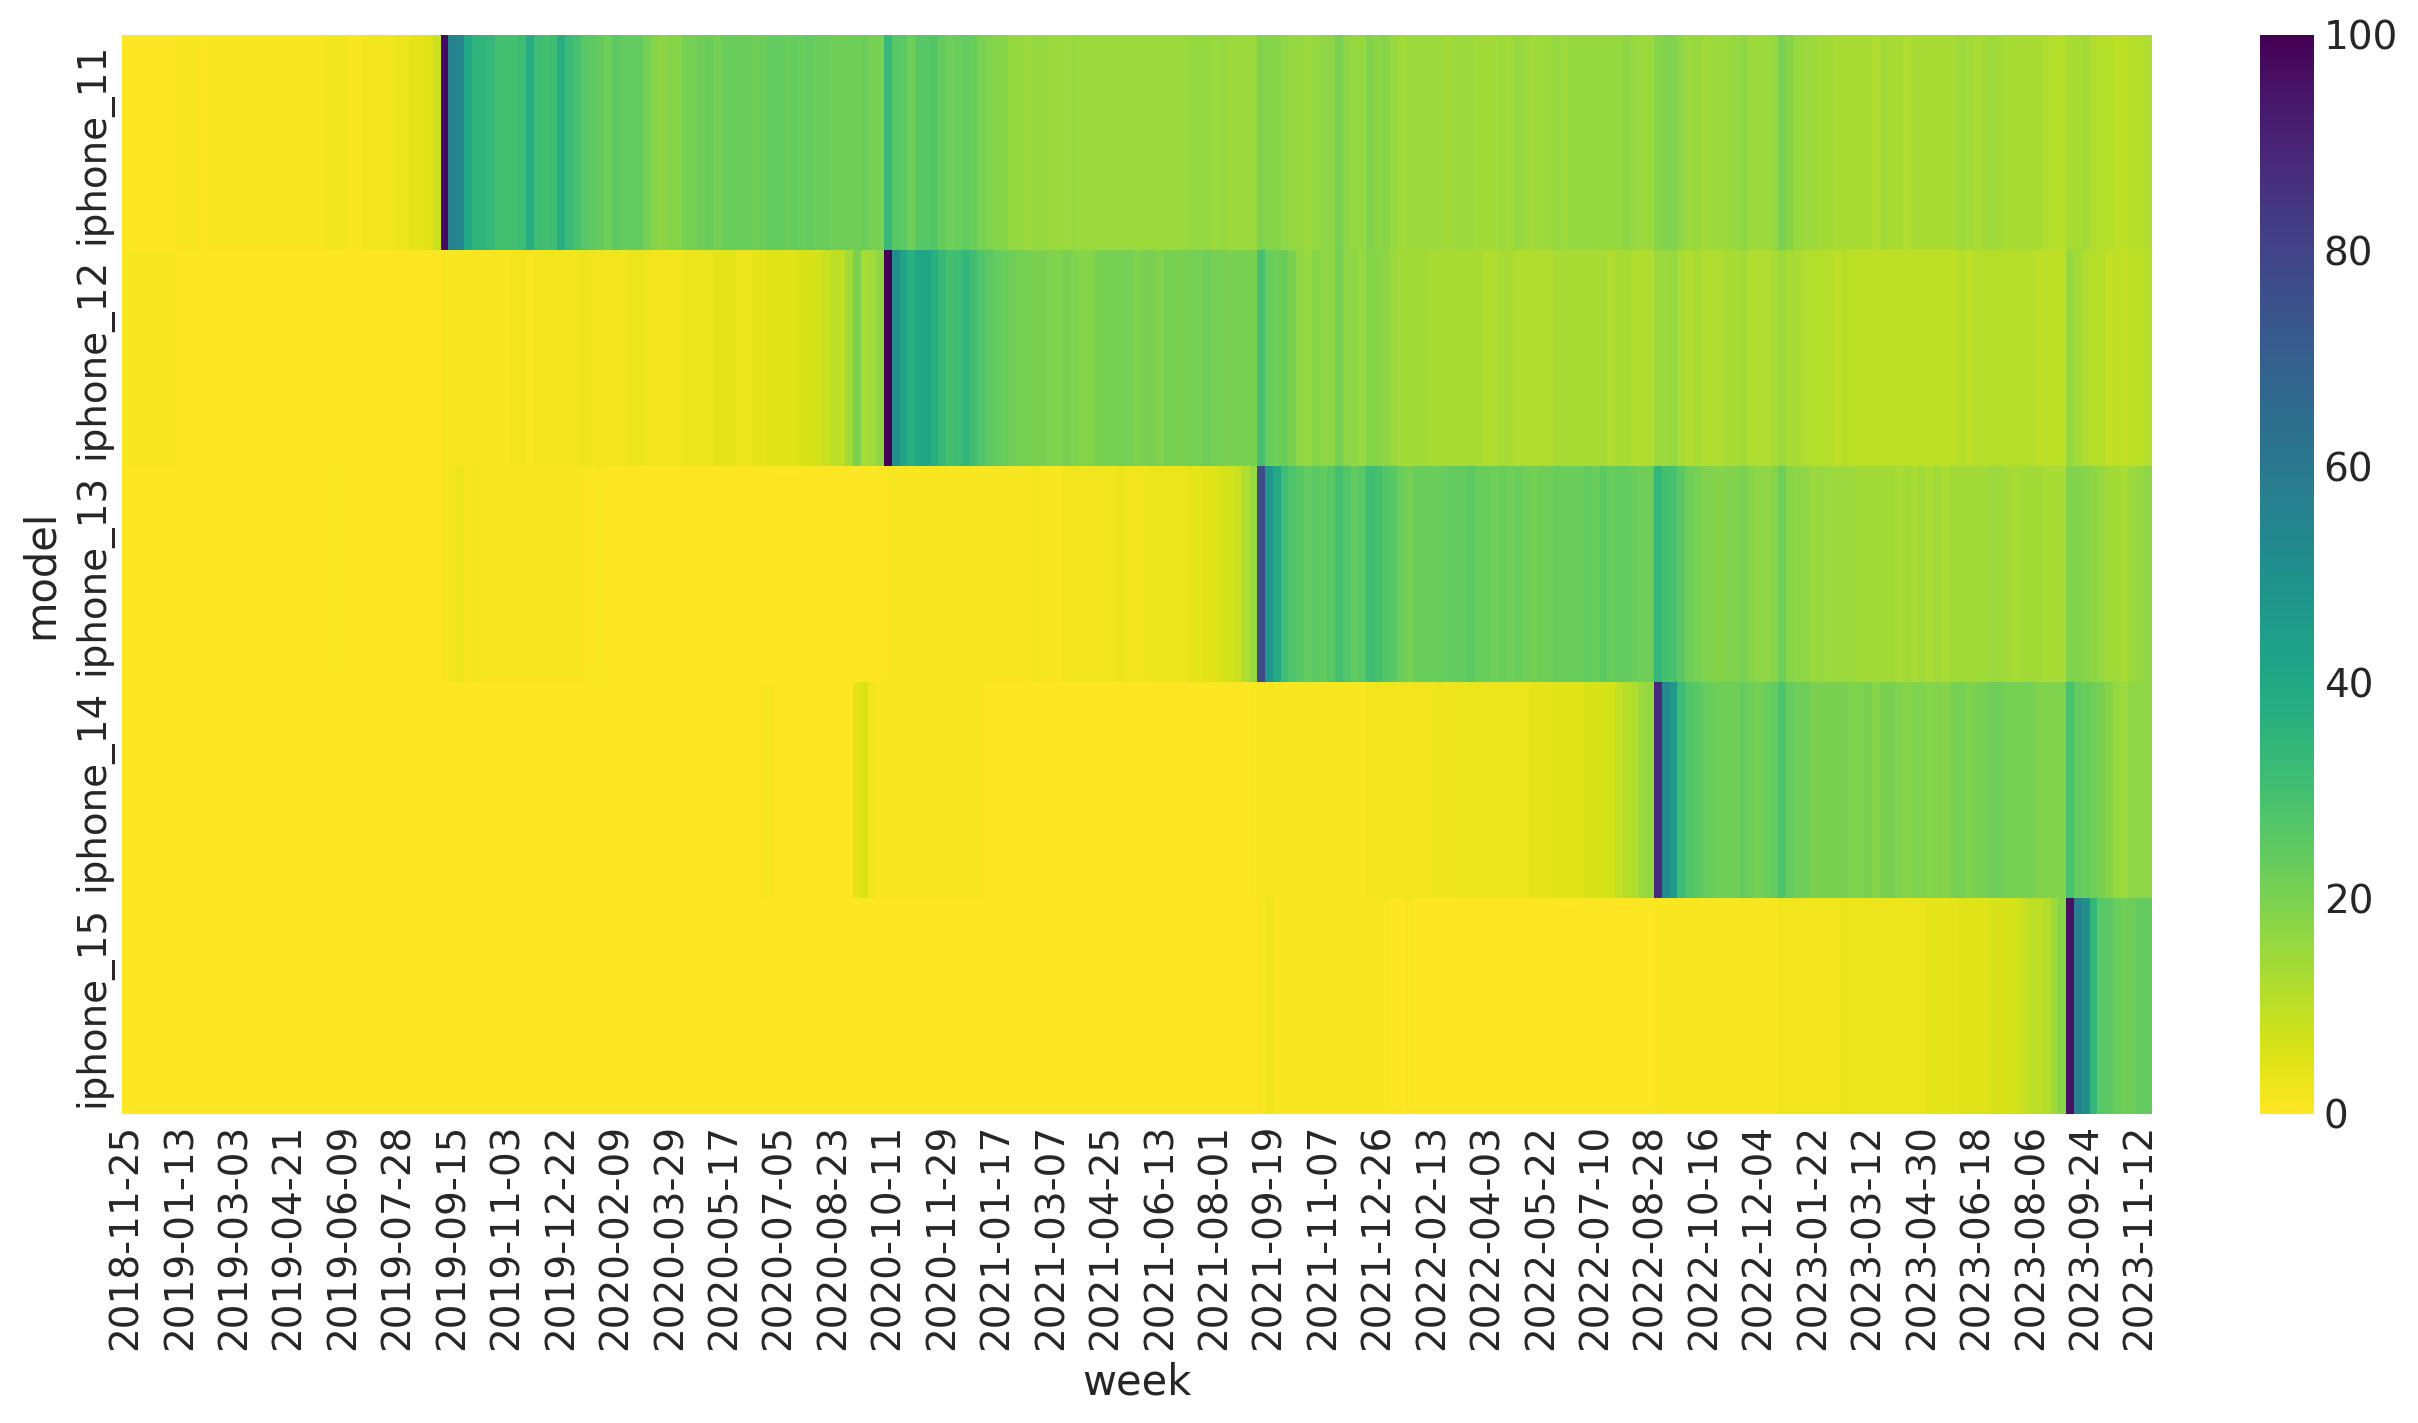

In [6]:
fig, ax = plt.subplots()
(
    data_df.assign(week=lambda x: x["week"].dt.date)[["model", "week", "search"]]
    .pivot(index="model", columns="week", values="search")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        ax=ax,
    )
)